In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")


In [ ]:
# ⬅️ change this to your file path & sheet if needed
file_path = r"D:/arima project/data/Obesity+DM+HTN age groups final.xlsx"
sheet = "data final"

df = pd.read_excel(file_path, sheet_name=sheet)

# Clean column names: strip, collapse spaces, and keep a lowercase alias
df.columns = [c.strip() for c in df.columns]
clean_map = {c: " ".join(c.split()).lower() for c in df.columns}  # alias we’ll search on
clean_map  # just to inspect


In [ ]:
def find_aamr_column(columns_map):
    # columns_map: dict original->lower_clean
    candidates = []
    for orig, low in columns_map.items():
        if ("age" in low and "adjust" in low) or "aamr" in low or "age-adjust" in low or "age_adjust" in low:
            # avoid obvious percentage columns
            if "%" not in orig and "percent" not in low:
                candidates.append(orig)
    # If multiple matches, pick the first (you can change the index once you confirm)
    return candidates

aamr_candidates = find_aamr_column(clean_map)
print("AAMR-like columns I found:", aamr_candidates)

# Choose the first candidate by default
if not aamr_candidates:
    raise ValueError("Could not find an AAMR column. Please print df.columns and tell me which one is AAMR.")
AAMR_COL = aamr_candidates[0]
print("Using AAMR column:", AAMR_COL)


In [ ]:
# Ensure Year is integer and sorted
df["Year"] = pd.to_numeric(df["Year"], errors="coerce").astype("Int64")
df = df.dropna(subset=["Year"]).sort_values("Year")

# Quick glimpse
display(df.head(10))
print("Age groups:", df["Age group"].unique())


In [ ]:
def fit_best_arima(series, p_range=(0,2), d_range=(0,2), q_range=(0,2)):
    series = series.astype(float)
    best_aic = np.inf
    best_order = None
    best_model = None
    for p, d, q in product(range(p_range[0], p_range[1]+1),
                           range(d_range[0], d_range[1]+1),
                           range(q_range[0], q_range[1]+1)):
        if p == d == q == 0:
            continue
        try:
            model = ARIMA(series, order=(p,d,q))
            fitted = model.fit()
            if fitted.aic < best_aic:
                best_aic = fitted.aic
                best_order = (p,d,q)
                best_model = fitted
        except Exception:
            continue
    if best_model is None:
        raise RuntimeError("No ARIMA model could be fit. Try widening the grid or checking the series.")
    return best_model, best_order, best_aic


In [ ]:
forecast_horizon = 15
results_all = []

for grp, gdf in df.groupby("Age group"):
    s = gdf.set_index("Year")[AAMR_COL].astype(float)
    s = s.dropna()
    if len(s) < 8:
        print(f"Skipping {grp}: too few data points ({len(s)})")
        continue

    best_model, order, aic = fit_best_arima(s, p_range=(0,2), d_range=(0,2), q_range=(0,2))
    print(f"[{grp}] best order={order}, AIC={aic:.2f}")

    # Forecast
    last_year = int(s.index.max())
    future_index = list(range(last_year+1, last_year+1+forecast_horizon))
    fc = best_model.forecast(steps=forecast_horizon)
    fc = pd.Series(fc.values, index=future_index, name="forecast")

    # Combine
    out = pd.DataFrame({
        "Age group": grp,
        "Year": list(s.index) + future_index,
        "AAMR": list(s.values) + [np.nan]*forecast_horizon,
        "Forecast": [np.nan]*len(s) + list(fc.values),
        "Model": str(order),
        "AIC": aic
    })
    results_all.append(out)

    # Plot
    plt.figure(figsize=(9,4))
    plt.plot(s.index, s.values, label="Observed")
    plt.plot(fc.index, fc.values, "--o", label="Forecast")
    #plt.title(f"AAMR ({AAMR_COL}) — {grp}")
    plt.xlabel("Year"); plt.ylabel("AAMR")
    plt.legend(); 
    plt.show()

results_age = pd.concat(results_all, ignore_index=True)
results_age.head()


In [271]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from pmdarima import auto_arima

plt.rcParams.update({
    "figure.figsize": (14, 7),
    "figure.dpi": 140,
    "axes.grid": True,
    "grid.alpha": 0.3,
    "font.size": 12
})


In [272]:
# === EDIT THESE ===
FILE_PATH   = r"D:\arima project\data\Obesity+DM+HTN age groups final.xlsx"
SHEET_NAME  = "data final"          # e.g., "data final" if you know it; else None to auto-pick
GROUP_VALUE = "Young"      # e.g., "Male", "Young", "Old", "South", "Black", etc.
HORIZON_YEARS = 20
OUTPUT_DIR  = Path("./arima_plots")

# If your file is overall with NO grouping column, set GROUP_VALUE = None


In [273]:
xls = pd.ExcelFile(FILE_PATH)
print("Sheets found:", xls.sheet_names)

chosen = (
    SHEET_NAME
    or next((s for s in xls.sheet_names if "data" in s.lower() and "final" in s.lower()), None)
    or xls.sheet_names[0]
)
df = pd.read_excel(xls, sheet_name=chosen)
print("Using sheet:", chosen)
df.head(3)


Sheets found: ['data final', 'young 1999-2020', 'young 21-23', 'middle 1999-2020', 'middle 21-23', 'old 1999-2020', 'old 21-23', 'graph', 'JP']
Using sheet: data final


,Age group,Year,Year Code,Deaths,Population,Crude Rate,Crude Rate Lower 95% Confidence Interval,Crude Rate Upper 95% Confidence Interval,Crude Rate Standard Error,Age Adjusted Rate,Age Adjusted Rate Lower 95% Confidence Interval,Age Adjusted Rate Upper 95% Confidence Interval,Age Adjusted Rate Standard Error,% of Total Deaths
0,Young,1999,1999,182,85255083,0.21,0.18,0.24,0.02,0.21,0.18,0.24,0.02,0.0093
1,Young,2000,2000,413,85040251,0.49,0.44,0.53,0.02,0.48,0.43,0.53,0.02,0.0210
2,Young,2001,2001,393,84523274,0.46,0.42,0.51,0.02,0.48,0.43,0.53,0.02,0.0200


In [274]:
def _pick_col(df, patterns, exclude=None, required=True):
    cols = list(df.columns)
    low = {c: c.lower().strip() for c in cols}
    for pat in patterns:
        rx = re.compile(pat)
        for c, lc in low.items():
            if rx.search(lc):
                if exclude and any(ex in lc for ex in exclude):
                    continue
                return c
    if required:
        raise KeyError(f"Could not find a column matching any of: {patterns}")
    return None

def find_year_col(df):
    return _pick_col(df, [r"\byear\b", r"^yr$"])

def find_target_col(df):
    # avoid % of total deaths etc.
    return _pick_col(
        df,
        [r"\baamr\b",
         r"age\s*adjust(?:ed)?(?:\s*rate)?",
         r"age[-\s]*adj(?:usted)?\s*rate?",
         r"age[-\s]*standard(?:ized)?\s*rate?"],
        exclude=["%", "percent", "total", "deaths"]
    )

def find_group_col(df):
    return _pick_col(
        df,
        [r"\bgender\b", r"\bsex\b",
         r"\bage\s*group\b", r"\bagegroup\b", r"^\bage\b$",
         r"\brace\b", r"ethnic",
         r"\bregion\b", r"census",
         r"\bstate\b",
         r"urban", r"urbanization",
         r"\bplace of death\b", r"\bpod\b"],
        required=False
    )


In [275]:
YEAR_COL   = find_year_col(df)
TARGET_COL = find_target_col(df)
GROUP_COL  = find_group_col(df)  # may be None

print(f"Detected → YEAR_COL='{YEAR_COL}', TARGET_COL='{TARGET_COL}', GROUP_COL='{GROUP_COL}'")

if GROUP_COL:
    opts = sorted(df[GROUP_COL].astype(str).str.strip().unique())
    print("Available group values (first 40):", opts[:40])


Detected → YEAR_COL='Year', TARGET_COL='Age Adjusted Rate', GROUP_COL='Age group'
Available group values (first 40): ['Middle', 'Old', 'Young']


In [276]:
use = df.copy()

# clean types
use[YEAR_COL] = pd.to_numeric(use[YEAR_COL], errors="coerce")
use[TARGET_COL] = pd.to_numeric(use[TARGET_COL], errors="coerce")
if GROUP_COL:
    use[GROUP_COL] = use[GROUP_COL].astype(str).str.strip()

use = use.dropna(subset=[YEAR_COL, TARGET_COL])

if GROUP_COL and GROUP_VALUE is not None:
    gdf = use[use[GROUP_COL].str.lower() == GROUP_VALUE.strip().lower()].copy()
    if gdf.empty:
        raise ValueError(f"'{GROUP_VALUE}' not found in '{GROUP_COL}'. "
                         "Pick one from the list printed above.")
    # average if multiple rows per year
    gdf = (gdf[[YEAR_COL, TARGET_COL]]
           .groupby(YEAR_COL, as_index=False).mean()
           .sort_values(YEAR_COL))
    series_name = f"{GROUP_VALUE} AAMR"
else:
    # overall
    gdf = (use[[YEAR_COL, TARGET_COL]]
           .groupby(YEAR_COL, as_index=False).mean()
           .sort_values(YEAR_COL))
    series_name = "Overall AAMR"

y = pd.Series(
    gdf[TARGET_COL].values,
    index=pd.to_datetime(gdf[YEAR_COL].astype(int).astype(str) + "-01-01"),
    name=series_name
).asfreq("YS")

print(f"Series span: {y.index[0].year}–{y.index[-1].year}; n={len(y)}")
y.tail()


Series span: 1999–2023; n=25


Year
2019-01-01    1.59
2020-01-01    2.70
2021-01-01    3.49
2022-01-01    2.43
2023-01-01    2.01
Freq: YS-JAN, Name: Young AAMR, dtype: float64

In [277]:
model = auto_arima(
    y.dropna(),
    start_p=0, start_q=0, max_p=5, max_q=5,
    d=None, seasonal=False, m=1,
    start_P=0, start_Q=0, max_P=0, max_Q=0,
    information_criterion="aic",
    stepwise=True, error_action="ignore",
    suppress_warnings=True, trace=False
)
order = model.order
print("Selected ARIMA order:", order)


Selected ARIMA order: (0, 1, 0)


In [278]:
n = HORIZON_YEARS
fc, ci = model.predict(n_periods=n, return_conf_int=True, alpha=0.05)

last_year = y.index[-1].year
fut_index = pd.date_range(f"{last_year+1}-01-01", periods=n, freq="YS")

y_fc = pd.Series(fc, index=fut_index, name="Forecast")
ci_lower = pd.Series(ci[:, 0], index=fut_index, name="Lower95")
ci_upper = pd.Series(ci[:, 1], index=fut_index, name="Upper95")

forecast_df = pd.concat([y, y_fc, ci_lower, ci_upper], axis=1)
forecast_df.tail()


,Young AAMR,Forecast,Lower95,Upper95
2039-01-01,NaN,2.01,-0.917962,4.937962
2040-01-01,NaN,2.01,-1.008075,5.028075
2041-01-01,NaN,2.01,-1.095573,5.115573
2042-01-01,NaN,2.01,-1.180673,5.200673
2043-01-01,NaN,2.01,-1.263561,5.283561


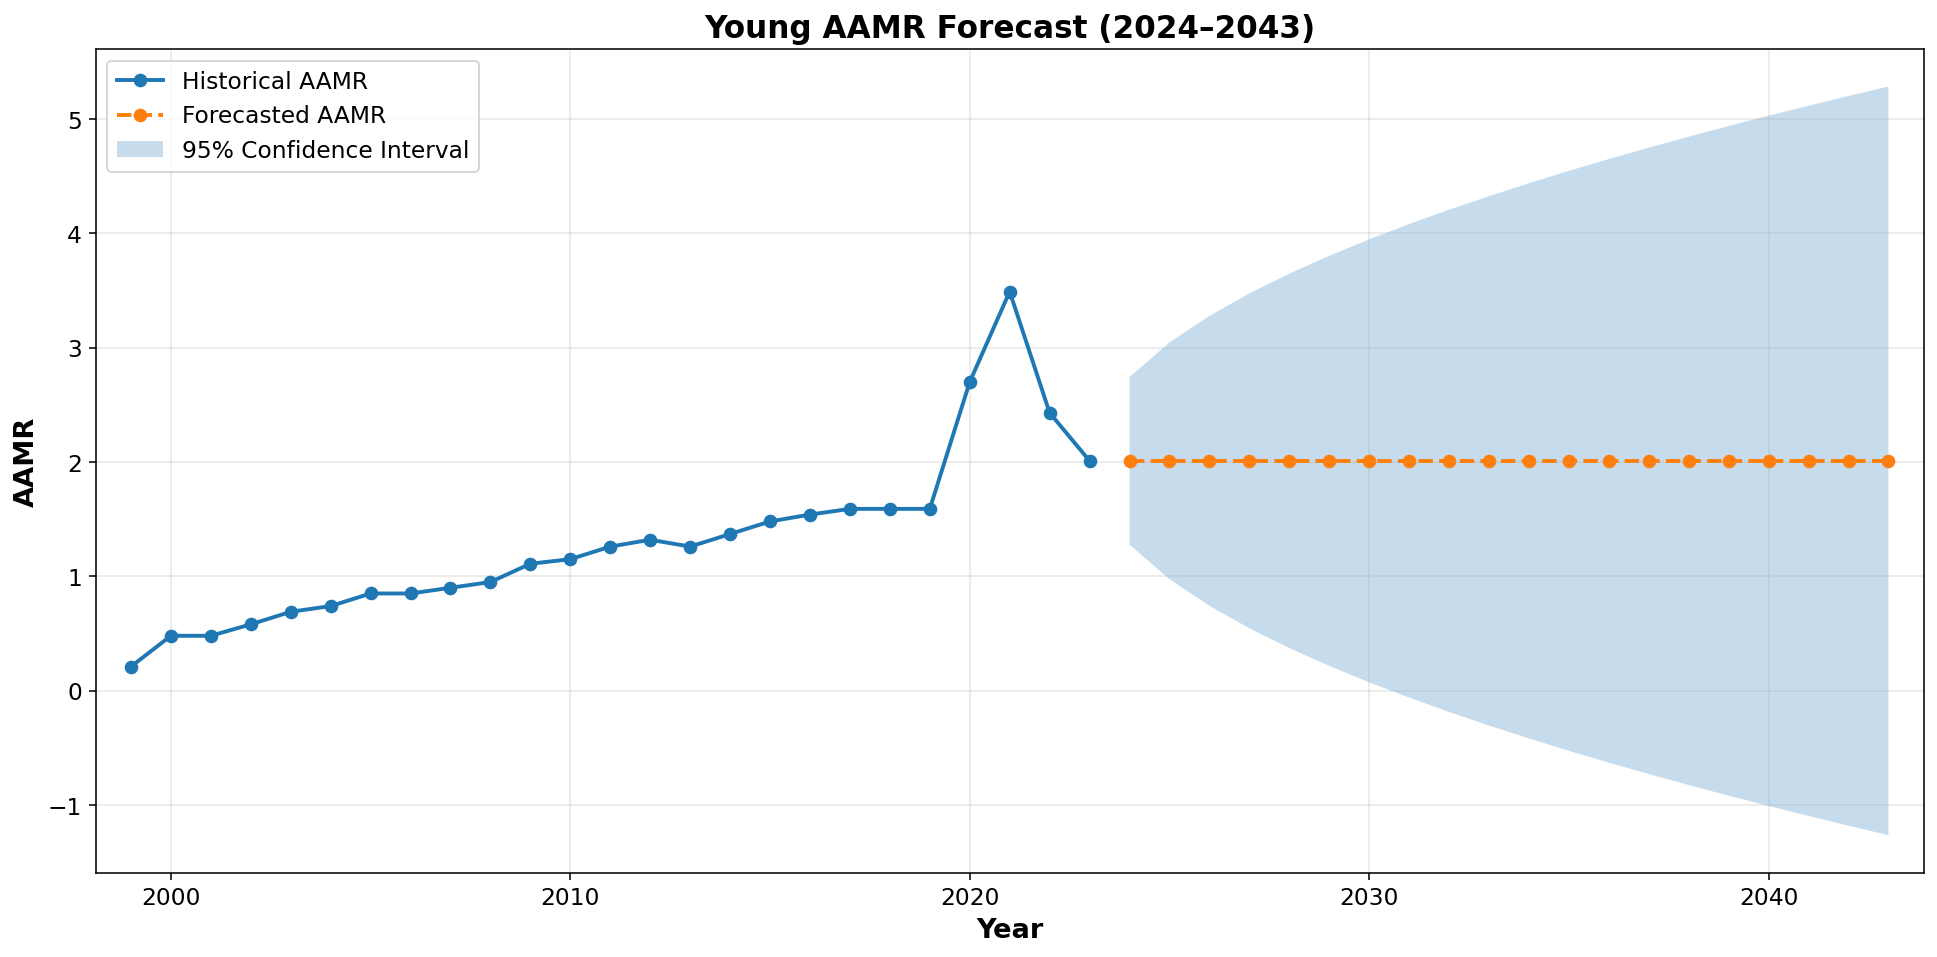

In [279]:
start_f, end_f = fut_index[0].year, fut_index[-1].year
title = f"{series_name} Forecast ({start_f}–{end_f})"

fig, ax = plt.subplots()

# historical
ax.plot(y.index.year, y.values, marker="o", linewidth=2, label="Historical AAMR")

# forecast
ax.plot(y_fc.index.year, y_fc.values, marker="o", linewidth=2, linestyle="--", label="Forecasted AAMR")

# 95% CI band
ax.fill_between(y_fc.index.year, ci_lower.values, ci_upper.values, alpha=0.25, label="95% Confidence Interval")

# cosmetics
ax.set_xlabel("Year", fontsize=14, weight="bold")
ax.set_ylabel("AAMR", fontsize=14, weight="bold")
ax.set_title(title, fontsize=16, weight="bold")
ax.legend(loc="upper left", frameon=True)
ax.margins(x=0.02)

plt.tight_layout()
plt.show()


In [280]:
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def safe(s): 
    return re.sub(r"[^a-zA-Z0-9_-]+", "_", str(s))

png_path = OUTPUT_DIR / f"{safe(title)}.png"
csv_path = OUTPUT_DIR / f"{safe(series_name)}_{start_f}_{end_f}.csv"

# save figure & data
fig = plt.gcf()
fig.savefig(png_path, dpi=300, bbox_inches="tight")

# tidy table with Year column
out = forecast_df.copy()
out["Year"] = out.index.year
out = out[["Year", series_name, "Forecast", "Lower95", "Upper95"]]
out.to_csv(csv_path, index=False)

print("Saved plot to:", png_path.resolve())
print("Saved data to:", csv_path.resolve())


Saved plot to: D:\arima project\code\arima_plots\Young_AAMR_Forecast_2024_2043_.png
Saved data to: D:\arima project\code\arima_plots\Young_AAMR_2024_2043.csv


<Figure size 1960x980 with 0 Axes>

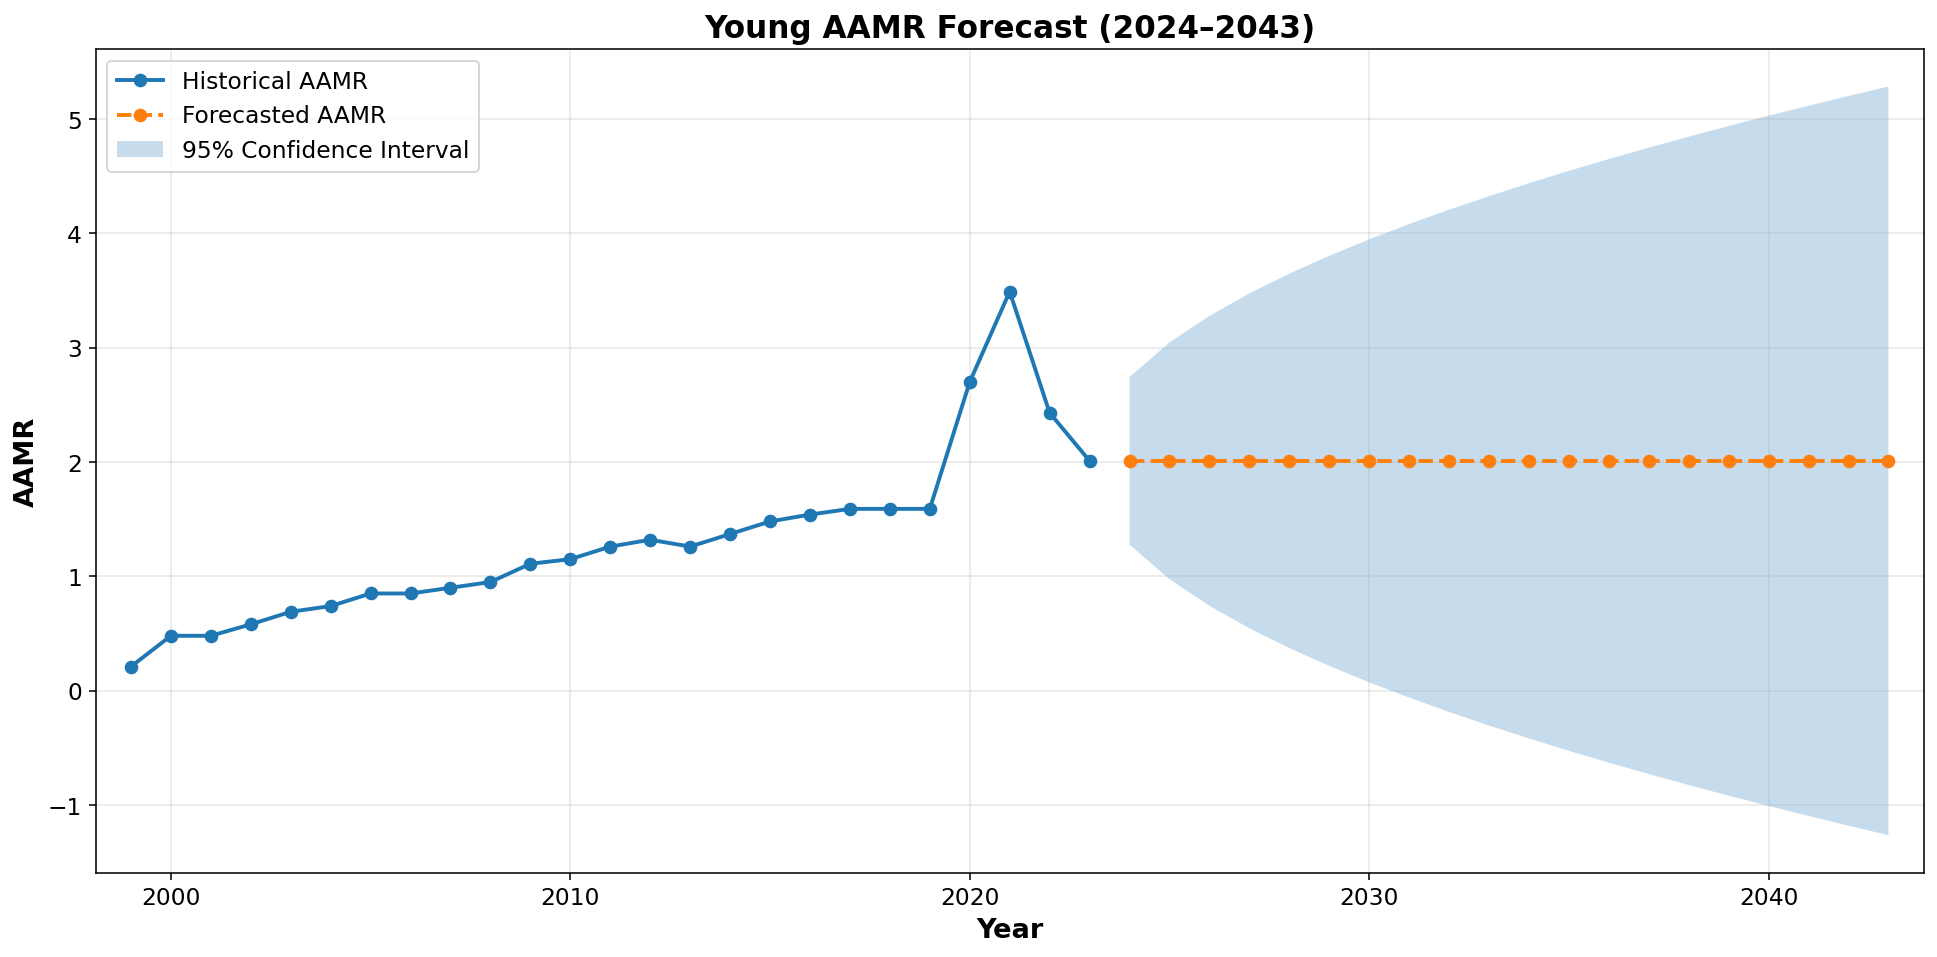

In [281]:
start_f, end_f = fut_index[0].year, fut_index[-1].year
title = f"{series_name} Forecast ({start_f}–{end_f})"

fig, ax = plt.subplots()

# historical
ax.plot(y.index.year, y.values, marker="o", linewidth=2, label="Historical AAMR")

# forecast
ax.plot(y_fc.index.year, y_fc.values, marker="o", linewidth=2, linestyle="--", label="Forecasted AAMR")

# 95% CI band (ensure numpy arrays to avoid alignment surprises)
ax.fill_between(
    y_fc.index.year,
    getattr(ci_lower, "to_numpy", lambda: ci_lower)(),
    getattr(ci_upper, "to_numpy", lambda: ci_upper)(),
    alpha=0.25,
    label="95% Confidence Interval"
)

# cosmetics
ax.set_xlabel("Year", fontsize=14, weight="bold")
ax.set_ylabel("AAMR", fontsize=14, weight="bold")
ax.set_title(title, fontsize=16, weight="bold")
ax.legend(loc="upper left", frameon=True)
ax.margins(x=0.02)
fig.tight_layout()

# ----- SAVE THE SAME FIG -----
fig.savefig(png_path, dpi=300, bbox_inches="tight")  # <- save here
# plt.show()  # optional; if you need it, call AFTER saving
# plt.close(fig)  # optional, to free memory


In [282]:
# !pip install pandas numpy matplotlib openpyxl
import re, glob
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    "figure.figsize": (12, 6.5),
    "figure.dpi": 140,
    "axes.grid": True,
    "grid.alpha": 0.3,
    "font.size": 12,
    "legend.frameon": True
})


In [283]:
def _pick_col(df, patterns, exclude=None, required=True):
    low = {c: str(c).strip().lower() for c in df.columns}
    for pat in patterns:
        rx = re.compile(pat)
        for c, lc in low.items():
            if rx.search(lc):
                if exclude and any(ex in lc for ex in exclude):
                    continue
                return c
    if required:
        raise KeyError(f"Could not find any of {patterns}")
    return None

def find_year(df):   return _pick_col(df, [r"\byear\b", r"^yr$"])
def find_group(df):  return _pick_col(df, [r"\bgender\b", r"\bsex\b", r"\bage\s*group\b", r"\brace\b", r"ethnic", r"\bregion\b", r"census", r"\bstate\b", r"urban"])
def find_aamr(df):   return _pick_col(df, [r"\baamr\b", r"age\s*adjust", r"age[-\s]*adj", r"age[-\s]*standard"], exclude=["%", "percent", "total"])

def load_observed_excel(excel_path, sheet_name=None):
    """Return tidy observed data: columns = Year, Group, AAMR"""
    xls = pd.ExcelFile(excel_path)
    chosen = sheet_name or next((s for s in xls.sheet_names if "data" in s.lower() and "final" in s.lower()), xls.sheet_names[0])
    df = pd.read_excel(xls, sheet_name=chosen)
    ycol = find_year(df); gcol = find_group(df); tcol = find_aamr(df)
    df = df[[ycol, gcol, tcol]].copy()
    df[ycol] = pd.to_numeric(df[ycol], errors="coerce")
    df[tcol] = pd.to_numeric(df[tcol], errors="coerce")
    df = df.dropna(subset=[ycol, gcol, tcol])
    df[gcol] = df[gcol].astype(str).str.strip()
    # aggregate duplicates per year/group
    tidy = (df.groupby([ycol, gcol], as_index=False)[tcol].mean()
            .rename(columns={ycol:"Year", gcol:"Group", tcol:"AAMR"}))
    return tidy

def _read_any_table(path):
    if path.suffix.lower() in [".xlsx", ".xlsm", ".xls"]:
        return pd.read_excel(path)
    return pd.read_csv(path)

def _detect_forecast_cols(df):
    # Format A: Forecast, Lower95, Upper95
    a = ["Forecast", "Lower95", "Upper95"]
    # Format B: Point.Forecast, Lo.95, Hi.95  (your Excel export)
    b = ["Point.Forecast", "Lo.95", "Hi.95"]
    has_a = all(c in df.columns for c in a)
    has_b = all(c in df.columns for c in b)
    if has_a:
        return ("Forecast", "Lower95", "Upper95")
    if has_b:
        return ("Point.Forecast", "Lo.95", "Hi.95")
    raise KeyError("Could not find forecast columns. Expected Forecast/Lower95/Upper95 or Point.Forecast/Lo.95/Hi.95.")

def label_from_filename(p: Path):
    name = p.stem
    name = re.sub(r"_forecast.*$", "", name, flags=re.I)
    name = re.sub(r"[_\-]+", " ", name).strip()
    return name.title()

def load_forecasts_dir(forecast_dir: str | Path):
    """
    Returns dict: subgroup -> DataFrame[Year, F, L95, U95]
    Accepts .csv or .xlsx in the folder.
    """
    d = {}
    files = [Path(p) for p in glob.glob(str(Path(forecast_dir) / "*.*")) if p.lower().endswith((".csv",".xlsx",".xlsm",".xls"))]
    if not files:
        raise FileNotFoundError(f"No forecast files found under {forecast_dir}")
    for p in files:
        df = _read_any_table(p)
        # try to find Year
        ycol = _pick_col(df, [r"\byear\b"])
        fcol, l95, u95 = _detect_forecast_cols(df)
        sub = None
        # If a dedicated column exists for the series name, prefer it
        for cand in ["Series", "series_name", "Group", "group"]:
            if cand in df.columns:
                vals = df[cand].dropna().astype(str).unique()
                if len(vals)==1:
                    sub = vals[0]
                break
        if not sub:
            sub = label_from_filename(p)
        cur = df[[ycol, fcol, l95, u95]].copy()
        cur = cur.rename(columns={ycol:"Year", fcol:"Forecast", l95:"Lower95", u95:"Upper95"})
        cur["Group"] = str(sub).strip()
        # Keep only future years to avoid double-plotting history from a combined file
        cur = cur.sort_values("Year")
        d[sub] = cur
    return d


In [ ]:
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_combined_timeseries(category_name, observed_df, forecasts_dict, year_break=2023, save_dir=Path("./combined_plots")):
    """
    One plot per category: overlays observed (≤year_break) and forecasts (>year_break) for all subgroups,
    including 95% prediction intervals (CI bands).
    """
    save_dir.mkdir(parents=True, exist_ok=True)

    observed_df = observed_df.copy()
    observed_df["Group_norm"] = observed_df["Group"].fillna("").str.strip().str.lower()

    observed_groups = set(observed_df["Group_norm"].unique())
    forecast_groups = {str(k).strip(): str(k).strip() for k in forecasts_dict.keys()}
    groups_norm = sorted(observed_groups | {g.lower() for g in forecast_groups.keys()})

    display_label = {}
    for gn in groups_norm:
        for fk in forecast_groups.keys():
            if fk.lower() == gn:
                display_label[gn] = fk
                break
        else:
            m = observed_df.loc[observed_df["Group_norm"] == gn, "Group"]
            display_label[gn] = m.iloc[0] if not m.empty else gn

    fig, ax = plt.subplots(figsize=(13, 7))

    for gn in groups_norm:
        disp = display_label[gn]

        # observed
        obs = observed_df.loc[observed_df["Group_norm"] == gn]
        obs_seg = obs[obs["Year"] <= year_break]
        if not obs_seg.empty:
            ax.plot(obs_seg["Year"], obs_seg["AAMR"], linewidth=2, marker="o", label=f"{disp} (obs)")

        # forecast
        fc_df = None
        for fk, df in forecasts_dict.items():
            if str(fk).strip().lower() == gn:
                fc_df = df
                break
        if fc_df is None:
            continue

        fc_seg = fc_df[fc_df["Year"] > year_break]
        if not fc_seg.empty:
            ax.plot(
                fc_seg["Year"], fc_seg["Forecast"],
                linewidth=2, linestyle="--", marker="o", label=f"{disp} (fc)"
            )

            # 🔹 95% CI shaded band
            if "Lower95" in fc_seg and "Upper95" in fc_seg:
                ax.fill_between(
                    fc_seg["Year"], fc_seg["Lower95"], fc_seg["Upper95"],
                    alpha=0.15, label=f"{disp} 95% CI"
                )

            # annotate last forecast
            last_year = fc_seg["Year"].max()
            last_row = fc_seg.loc[fc_seg["Year"] == last_year]
            if not last_row.empty:
                y_last = last_row["Forecast"].iloc[0]
                x_last = last_row["Year"].iloc[0]
                ax.annotate(f"{y_last:.1f}", xy=(x_last, y_last),
                            xytext=(0, 6), textcoords="offset points",
                            ha="center", fontsize=9)

    ax.axvline(x=year_break + 0.5, linestyle=":", linewidth=1.5)
    ax.set_title(
        f"{category_name}: AAMR observed (1999–{year_break}) and ARIMA forecast ({year_break+1}–2043)",
        fontsize=16, fontweight="bold"
    )
    ax.set_xlabel("Year", fontsize=14, fontweight="bold")
    ax.set_ylabel("AAMR (per 100,000)", fontsize=14, fontweight="bold")
    ax.legend(ncols=2, fontsize=12)
    plt.tight_layout()

    out = save_dir / f"{re.sub(r'[^a-zA-Z0-9_-]+','_',category_name)}_combined_timeseries.png"
    fig.savefig(out, dpi=300, bbox_inches="tight")
    print("Saved:", out)
    plt.show()


def plot_2035_forest(category_name, forecasts_dict, year=2035, save_dir=Path("./combined_plots")):
    """
    One forest-style snapshot: subgroup 2043 point with 95% PI (error bars).
    """
    save_dir.mkdir(parents=True, exist_ok=True)

    rows = []
    for g, df in forecasts_dict.items():
        if df is None or df.empty or "Year" not in df:
            continue
        row = df.loc[df["Year"] == year]
        if row.empty:
            continue
        pt = row["Forecast"].iloc[0]
        lo = row["Lower95"].iloc[0]
        hi = row["Upper95"].iloc[0]
        rows.append((str(g), float(pt), float(lo), float(hi)))

    if not rows:
        raise ValueError(f"No {year} forecasts found.")

    rows = sorted(rows, key=lambda x: x[1], reverse=True)
    labels = [r[0] for r in rows]
    pts    = np.array([r[1] for r in rows], dtype=float)
    lo     = np.array([r[2] for r in rows], dtype=float)
    hi     = np.array([r[3] for r in rows], dtype=float)

    fig, ax = plt.subplots(figsize=(10, 0.5 * len(rows) + 1.5))
    y = np.arange(len(rows))

    # 🔹 Error bars = 95% PI
    xerr = np.vstack([pts - lo, hi - pts])
    ax.errorbar(pts, y, xerr=xerr, fmt="o", capsize=5, elinewidth=1.5, color="black")

    ax.set_yticks(y)
    ax.set_yticklabels(labels)
    ax.invert_yaxis()
    ax.set_xlabel(f"AAMR in {year} (per 100,000) — point with 95% PI", fontsize=14, fontweight="bold")
    ax.set_title(f"{category_name}: {year} forecast", fontsize=16, fontweight="bold")

    plt.tight_layout()
    out = save_dir / f"{re.sub(r'[^a-zA-Z0-9_-]+','_',category_name)}_{year}_forest.png"
    fig.savefig(out, dpi=300, bbox_inches="tight")
    print("Saved:", out)
    plt.show()


Saved: combined_plots\Gender_combined_timeseries.png


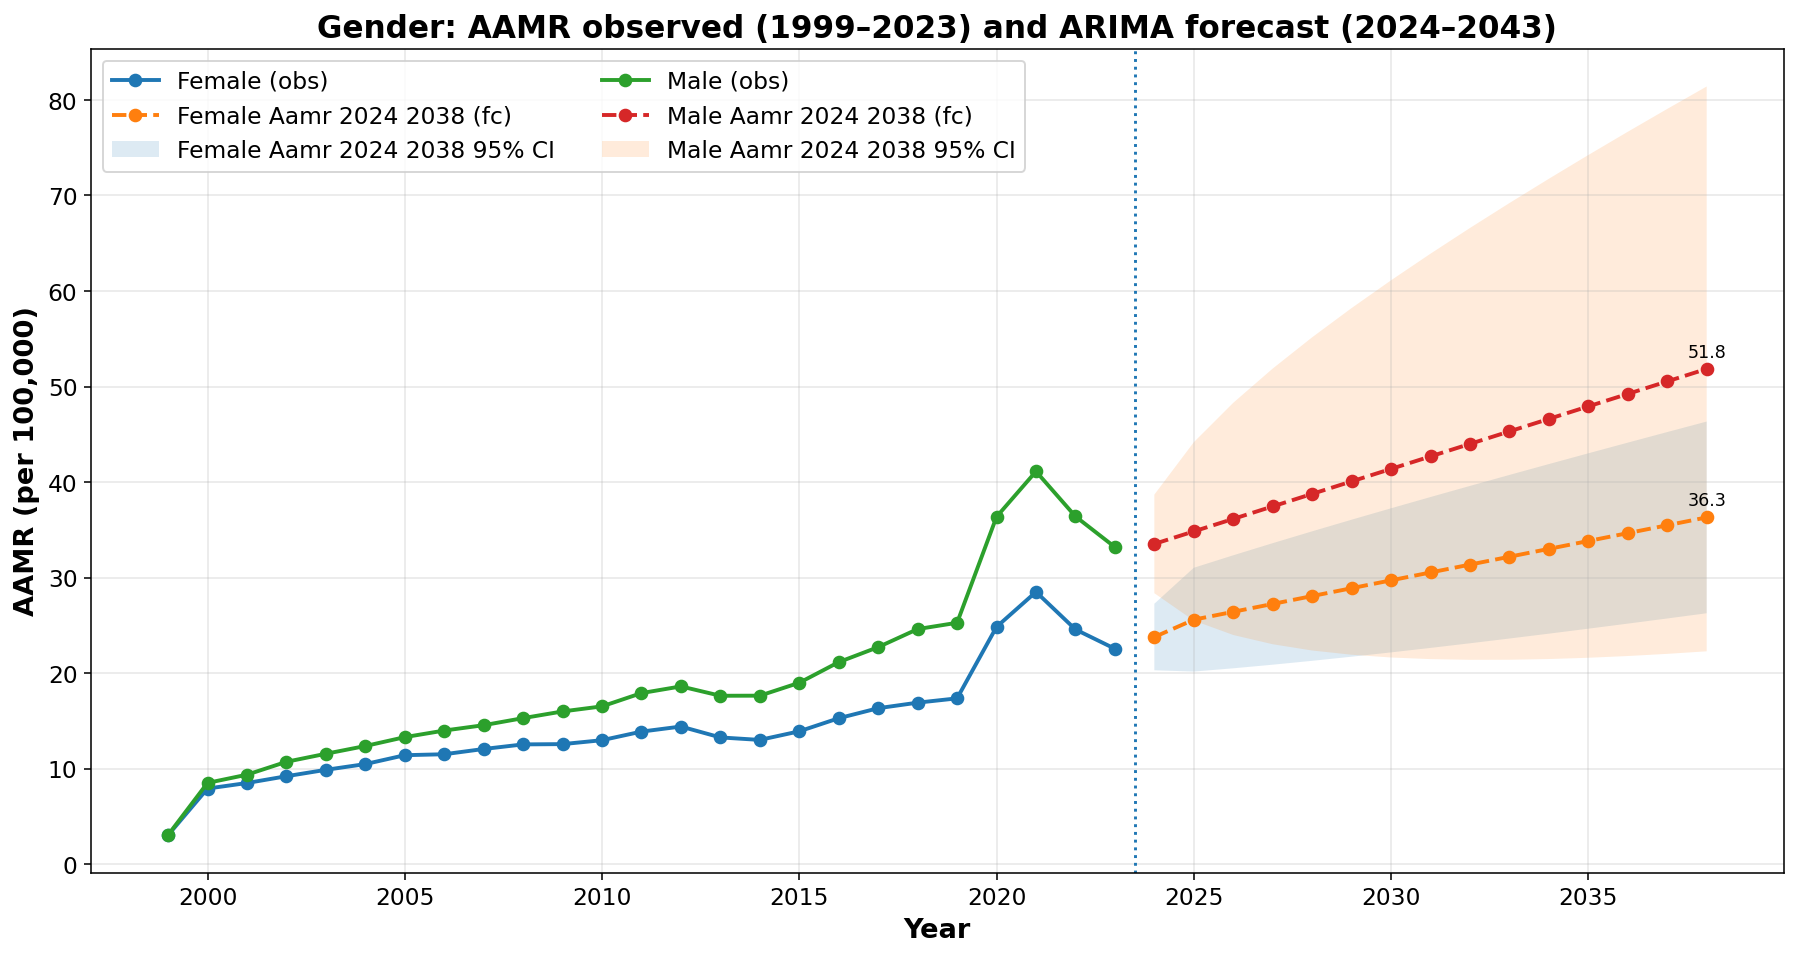

ValueError: No 2043 forecasts found.

In [ ]:
# ==== EDIT THESE FOR EACH CATEGORY ====
CATEGORY_NAME="Gender"
RAW_FILE=r"D:\arima project\data\obesity+DM+HTN gender final.xlsx"
FORECAST_DIR=r"D:\arima project\code\results\gender"
  # e.g., "Gender", "Age groups", "Race/ethnicity", "Census region", "Urbanization", "States"
SHEET_NAME    = None       # or e.g. "data final"                   # folder containing forecast CSV/XLSX for each subgroup
YEAR_BREAK    = 2023       # last observed year

# These loaders are assumed to be defined elsewhere in your codebase
observed = load_observed_excel(RAW_FILE, sheet_name=SHEET_NAME)
forecasts = load_forecasts_dir(FORECAST_DIR)

# Make the combined time-series and the 2035 forest
plot_combined_timeseries(CATEGORY_NAME, observed, forecasts, year_break=YEAR_BREAK)
plot_2035_forest(CATEGORY_NAME, forecasts, year=2035)


In [490]:
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from pmdarima import auto_arima


In [662]:
# === EDIT THESE ===
FILE_PATH   = r"D:\arima project\data\Obesity+DM+HTN urbanization final.xlsx"  # your observed data file
SHEET_NAME  = None                      # e.g., "data final" if known; else None to auto-pick
GROUP_VALUE = "nonmetro"                  # e.g., "Male", "Female", "Young", "Old", "NH White", "West", "Rural"; or None for overall
END_YEAR    = 2043                      # forecast horizon end
OUTPUT_DIR  = Path(r"D:\arima project\code\results\urbanization")  # where to save PNG/CSV/XLSX

# Tip: for an overall file (no subgroup column), set GROUP_VALUE = None


In [663]:
def _pick_col(df, patterns, exclude=None, required=True):
    low = {c: str(c).strip().lower() for c in df.columns}
    for pat in patterns:
        rx = re.compile(pat)
        for c, lc in low.items():
            if rx.search(lc):
                if exclude and any(ex in lc for ex in exclude):
                    continue
                return c
    if required:
        raise KeyError(f"Could not find a column matching any of: {patterns}")
    return None

def find_year_col(df):   return _pick_col(df, [r"\byear\b", r"^yr$"])
def find_group_col(df):  return _pick_col(df, [r"\bgender\b", r"\bsex\b", r"\bage\s*group\b", r"\brace\b", r"ethnic", r"\bregion\b", r"census", r"\bstate\b", r"urban"], required=False)
def find_aamr_col(df):   return _pick_col(df, [r"\baamr\b", r"age\s*adjust", r"age[-\s]*adj", r"age[-\s]*standard"], exclude=["%", "percent", "total"])

def safe(s): 
    return re.sub(r"[^a-zA-Z0-9_-]+", "_", str(s).strip())


In [664]:
xls = pd.ExcelFile(FILE_PATH)
print("Sheets found:", xls.sheet_names)

chosen = (
    SHEET_NAME
    or next((s for s in xls.sheet_names if "data" in s.lower() and "final" in s.lower()), None)
    or xls.sheet_names[0]
)
df = pd.read_excel(xls, sheet_name=chosen)
print("Using sheet:", chosen)
df.head(3)


Sheets found: ['final data', 'metro 1999-2020', 'nonmetro 1999-2020', 'graph', 'JP']
Using sheet: final data


,Urbanization,Year,Year Code,Deaths,Population,Crude Rate,Crude Rate Lower 95% Confidence Interval,Crude Rate Upper 95% Confidence Interval,Crude Rate Standard Error,Age Adjusted Rate,Age Adjusted Rate Lower 95% Confidence Interval,Age Adjusted Rate Upper 95% Confidence Interval,Age Adjusted Rate Standard Error,% of Total Deaths
0,metro,1999,1999,4330,151245342,2.86,2.78,2.95,0.04,3.02,2.93,3.11,0.05,0.0076
1,metro,2000,2000,11355,152658699,7.44,7.30,7.57,0.07,7.82,7.67,7.96,0.07,0.0199
2,metro,2001,2001,12499,154896258,8.07,7.93,8.21,0.07,8.44,8.29,8.59,0.08,0.0219


In [665]:
YEAR_COL   = find_year_col(df)
TARGET_COL = find_aamr_col(df)
GROUP_COL  = find_group_col(df)  # may be None

print(f"Detected → YEAR_COL='{YEAR_COL}', TARGET_COL='{TARGET_COL}', GROUP_COL='{GROUP_COL}'")

if GROUP_COL:
    opts = sorted(df[GROUP_COL].astype(str).str.strip().unique())
    print("Available groups (first 40):", opts[:40])


Detected → YEAR_COL='Year', TARGET_COL='Age Adjusted Rate', GROUP_COL='Urbanization'
Available groups (first 40): ['metro', 'nonmetro']


In [666]:
use = df.copy()
use[YEAR_COL]   = pd.to_numeric(use[YEAR_COL], errors="coerce")
use[TARGET_COL] = pd.to_numeric(use[TARGET_COL], errors="coerce")
if GROUP_COL:
    use[GROUP_COL] = use[GROUP_COL].astype(str).str.strip()
use = use.dropna(subset=[YEAR_COL, TARGET_COL])

if GROUP_COL and GROUP_VALUE is not None:
    gdf = use[use[GROUP_COL].str.lower() == GROUP_VALUE.strip().lower()].copy()
    if gdf.empty:
        raise ValueError(f"'{GROUP_VALUE}' not found in '{GROUP_COL}'. Pick from the list printed above.")
    gdf = (gdf[[YEAR_COL, TARGET_COL]]
           .groupby(YEAR_COL, as_index=False).mean()
           .sort_values(YEAR_COL))
    series_name = f"{GROUP_VALUE} AAMR"
else:
    gdf = (use[[YEAR_COL, TARGET_COL]]
           .groupby(YEAR_COL, as_index=False).mean()
           .sort_values(YEAR_COL))
    series_name = "Overall AAMR"

y = pd.Series(
    gdf[TARGET_COL].values,
    index=pd.to_datetime(gdf[YEAR_COL].astype(int).astype(str) + "-01-01"),
    name=series_name
).asfreq("YS")

print(f"Series span: {y.index[0].year}–{y.index[-1].year}; n={len(y)}")
y.tail()


Series span: 1999–2020; n=22


Year
2016-01-01    21.42
2017-01-01    23.51
2018-01-01    24.92
2019-01-01    26.28
2020-01-01    36.80
Freq: YS-JAN, Name: nonmetro AAMR, dtype: float64

In [667]:
model = auto_arima(
    y.dropna(),
    start_p=0, start_q=0, max_p=5, max_q=5,
    d=None, seasonal=False, m=1,
    start_P=0, start_Q=0, max_P=0, max_Q=0,
    information_criterion="aic",
    stepwise=True, error_action="ignore",
    suppress_warnings=True, trace=False
)
order = model.order
print("Selected ARIMA order:", order)


Selected ARIMA order: (0, 1, 0)


In [668]:
last_year = y.index[-1].year
HORIZON_YEARS = END_YEAR - last_year
if HORIZON_YEARS <= 0:
    raise ValueError(f"END_YEAR ({END_YEAR}) must be > last observed year ({last_year}).")

# Forecast with 95% and 80% PIs
fc95, ci95 = model.predict(n_periods=HORIZON_YEARS, return_conf_int=True, alpha=0.05)
fc80, ci80 = model.predict(n_periods=HORIZON_YEARS, return_conf_int=True, alpha=0.20)

fut_index = pd.date_range(f"{last_year+1}-01-01", periods=HORIZON_YEARS, freq="YS")

# Point forecast (same 'fc' across alpha runs)
y_fc = pd.Series(fc95, index=fut_index, name="Forecast")

ci_lower95 = pd.Series(ci95[:, 0], index=fut_index, name="Lower95")
ci_upper95 = pd.Series(ci95[:, 1], index=fut_index, name="Upper95")
ci_lower80 = pd.Series(ci80[:, 0], index=fut_index, name="Lo.80")
ci_upper80 = pd.Series(ci80[:, 1], index=fut_index, name="Hi.80")

# Two-decimal tables
excel_df = pd.DataFrame({
    "Year": y_fc.index.year,
    "Point.Forecast": y_fc.values,
    "Lo.80": ci_lower80.values,
    "Hi.80": ci_upper80.values,
    "Lo.95": ci_lower95.values,
    "Hi.95": ci_upper95.values,
}).round(2)

forecast_df = pd.concat([
    y.rename(series_name), 
    y_fc.rename("Forecast"),
    ci_lower95.rename("Lower95"),
    ci_upper95.rename("Upper95")
], axis=1).round(2)

excel_df.tail()


,Year,Point.Forecast,Lo.80,Hi.80,Lo.95,Hi.95
18,2039,67.05,53.00,81.09,45.57,88.53
19,2040,68.64,54.23,83.05,46.60,90.67
20,2041,70.23,55.47,84.99,47.65,92.81
21,2042,71.82,56.71,86.93,48.71,94.93
22,2043,73.41,57.96,88.87,49.78,97.05


Saved plot: D:\arima project\code\results\urbanization\nonmetro_AAMR_Forecast_2021-2043.png


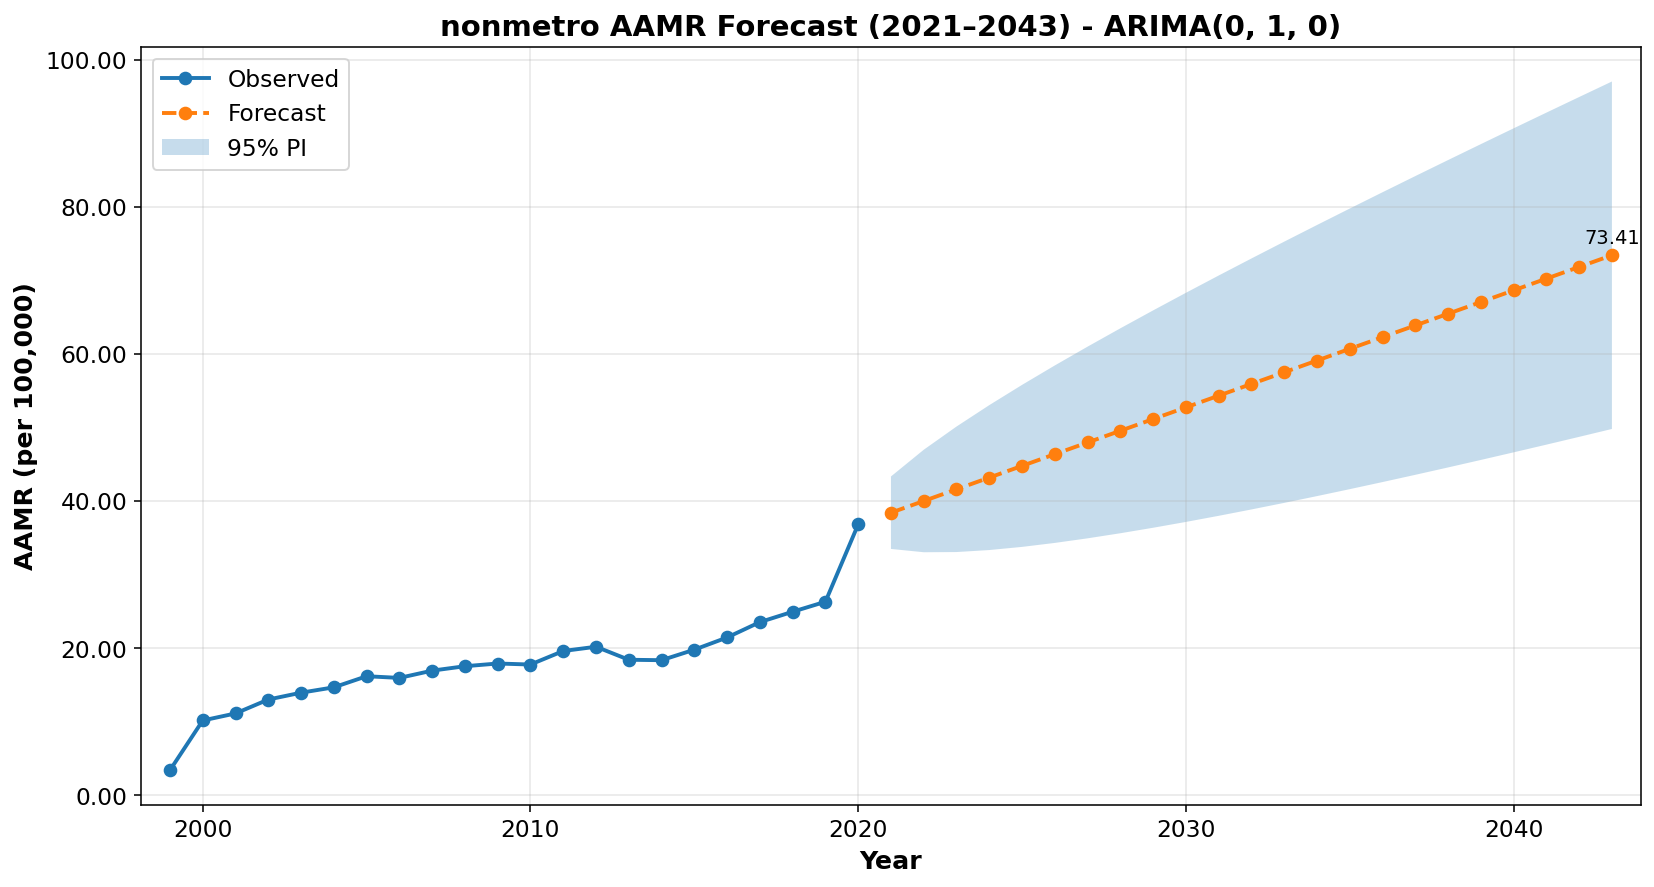

In [669]:
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

start_f, end_f = fut_index[0].year, fut_index[-1].year
assert end_f == END_YEAR, "Forecast did not reach END_YEAR."

title = f"{series_name} Forecast ({start_f}–{end_f}) - ARIMA{order}"

fig, ax = plt.subplots(figsize=(12, 6.5))
# observed
ax.plot(y.index.year, y.values, marker="o", linewidth=2, label="Observed")
# forecast
ax.plot(y_fc.index.year, y_fc.values, marker="o", linewidth=2, linestyle="--", label="Forecast")
# 95% PI band
ax.fill_between(y_fc.index.year, ci_lower95.values, ci_upper95.values, alpha=0.25, label="95% PI")

# annotate 2043 with two decimals
y_end = float(y_fc.iloc[-1])
ax.annotate(f"{y_end:.2f}", xy=(END_YEAR, y_end), xytext=(0,6),
            textcoords="offset points", ha="center", fontsize=10)

ax.set_xlabel("Year", fontsize=13, weight="bold")
ax.set_ylabel("AAMR (per 100,000)", fontsize=13, weight="bold")
ax.set_title(title, fontsize=15, weight="bold")
ax.legend(loc="upper left", frameon=True)
ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax.margins(x=0.02)
plt.tight_layout()
png_path = OUTPUT_DIR / f"{safe(series_name)}_Forecast_{start_f}-{end_f}.png"
fig.savefig(png_path, dpi=300, bbox_inches="tight")
print("Saved plot:", png_path)
plt.show()


In [670]:
csv_path  = OUTPUT_DIR / f"{safe(series_name)}_{start_f}_{end_f}.csv"
xlsx_path = OUTPUT_DIR / f"{safe(series_name)}_forecast_{start_f}-{end_f}.xlsx"

# CSV with Year column
out = forecast_df.copy()
out["Year"] = out.index.year
out = out[["Year", series_name, "Forecast", "Lower95", "Upper95"]].round(2)
out.to_csv(csv_path, index=False)

# Excel sheet like your template
with pd.ExcelWriter(xlsx_path, engine="openpyxl") as writer:
    excel_df.to_excel(writer, index=False, sheet_name=f"{safe(series_name).lower()}_forecast")

print("Saved CSV :", csv_path)
print("Saved XLSX:", xlsx_path)


Saved CSV : D:\arima project\code\results\urbanization\nonmetro_AAMR_2021_2043.csv
Saved XLSX: D:\arima project\code\results\urbanization\nonmetro_AAMR_forecast_2021-2043.xlsx


In [671]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Extract residuals from pmdarima
resid = None
for attr in ["arima_res_"]:
    obj = getattr(model, attr, None)
    if obj is not None and hasattr(obj, "resid"):
        resid = np.asarray(obj.resid)
        break
if resid is None:
    raise RuntimeError("Could not extract residuals for Ljung–Box test.")

lb = acorr_ljungbox(resid, lags=[5, 10], return_df=True)
lb.index = [f"Lag {i}" for i in lb.index]
print(lb)

lb_ok = (lb["lb_pvalue"] > 0.05).all()
print("Residual autocorrelation:",
      "OK (p>0.05 at both lags)" if lb_ok else "WARNING (autocorrelation detected)")

lb_csv = OUTPUT_DIR / f"{safe(series_name)}_ljungbox_{start_f}-{end_f}.csv"
lb.reset_index().rename(columns={"index":"Lag"}).to_csv(lb_csv, index=False)
print("Saved Ljung–Box CSV:", lb_csv)


         lb_stat  lb_pvalue
Lag 5   0.998299   0.962703
Lag 10  4.363827   0.929445
Residual autocorrelation: OK (p>0.05 at both lags)
Saved Ljung–Box CSV: D:\arima project\code\results\urbanization\nonmetro_AAMR_ljungbox_2021-2043.csv


In [672]:
from sklearn.metrics import mean_squared_error

def rolling_cv_rmse(series: pd.Series, folds: int = 10) -> float:
    """One-step-ahead expanding-window CV RMSE."""
    yv = series.dropna().values
    n  = len(yv)
    if n < folds + 5:
        raise ValueError("Too few points for 10-fold CV.")
    # split indices into folds starting after a warm-up
    warm = max(8, n // 3)
    idxs = list(range(warm, n-1))
    step = max(1, len(idxs)//folds)
    test_points = idxs[::step][:folds]

    preds, trues = [], []
    for t in test_points:
        train = series.iloc[:t+1].dropna()
        # fit fresh small auto_arima on train
        m = auto_arima(train, start_p=0, start_q=0, max_p=5, max_q=5,
                       d=None, seasonal=False, m=1,
                       start_P=0, start_Q=0, max_P=0, max_Q=0,
                       information_criterion="aic", stepwise=True,
                       error_action="ignore", suppress_warnings=True, trace=False)
        fc1 = m.predict(n_periods=1)[0]
        preds.append(fc1)
        trues.append(series.iloc[t+1])
    rmse = mean_squared_error(trues, preds, squared=False)
    return float(rmse)

rmse = rolling_cv_rmse(y)
print(f"Rolling CV RMSE (10 folds): {rmse:.2f}")


Rolling CV RMSE (10 folds): 1.58
